In [1]:
#!pip install qulacs
#!pip install qulacsvis
#!pip install matplotlib
#!pip install numpy
#!pip install scipy

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from qulacs import Observable, QuantumState, DensityMatrix, GeneralQuantumOperator
from qulacs.gate import  X, H, Z, DepolarizingNoise, DephasingNoise, AmplitudeDampingNoise, TwoQubitDepolarizingNoise, NoisyEvolution_fast

#  Qulacsでの混合状態
## DensityMatrixクラス：qulacsでの密度演算子（混合状態）の取り扱い

- 量子状態（密度演算子）の準備
- 密度演算子をnumpyのarrayに変換、あるいはその逆：`get_matrix()`, `load()`
- いくつかのエラー：`DepolarizingNoise`など
- 計算基底でのサンプリング：`sampling()`
- Lindblad方程式のシミュレーション：`NoisyEvolution_fast()`

## 量子状態（密度演算子）の準備

In [3]:
#密度演算子を準備
n_qubits = 1
density_matrix = DensityMatrix(n_qubits)
print(density_matrix)

 *** Density Matrix ***
 * Qubit Count : 1
 * Dimension   : 2
 * Density matrix : 
(1,0) (0,0)
(0,0) (0,0)



初期状態は$|0\rangle\langle 0|$になっている。行列成分の$(0,0)$成分が1で残りの成分がすべて0になっていることからも分かる。

## 密度演算子をnumpyのarrayに変換、あるいはその逆：`get_matrix()`, `load()`

In [4]:
#numpy arrayからqulacsのDensityMatrixへ変換
mat = np.array([[0.5, 0.5], [0.5, 0.5]])
density_matrix.load(mat)
print(density_matrix)

dm = density_matrix.get_matrix()
print(dm)

 *** Density Matrix ***
 * Qubit Count : 1
 * Dimension   : 2
 * Density matrix : 
(0.5,0) (0.5,0)
(0.5,0) (0.5,0)

[[0.5+0.j 0.5+0.j]
 [0.5+0.j 0.5+0.j]]


※上の量子状態は、実は純粋状態$|+\rangle$である。$|+\rangle\langle+|$を表示してみれば一致することが確認できる。

## いくつかのエラー：`DepolarizingNoise`など

Depolarizing noise: $\mathcal{E}[\rho]=(1-p)\rho+\frac{p}{3} (X\rho X+Y\rho Y+Z\rho Z)$ ($0\le p \le 0.75$)

In [5]:
#depolarizing noiseを作用
p = 0.15
gate = DepolarizingNoise(0, p)
gate.update_quantum_state(density_matrix)
print(density_matrix)

 *** Density Matrix ***
 * Qubit Count : 1
 * Dimension   : 2
 * Density matrix : 
(0.5,0) (0.4,0)
(0.4,0) (0.5,0)



Dephasing noise: $\mathcal{E}[\rho]=(1-p)\rho +p Z\rho Z$ ($0\le p \le 0.5$)

In [6]:
#dephasing noiseを作用
density_matrix.load(mat)

p=0.3
gate = DephasingNoise(0, p)
gate.update_quantum_state(density_matrix)
print(density_matrix)

 *** Density Matrix ***
 * Qubit Count : 1
 * Dimension   : 2
 * Density matrix : 
(0.5,0) (0.2,0)
(0.2,0) (0.5,0)



In [7]:
#２量子ビットの場合：depolarizing noiseを作用
density_matrix_2 = DensityMatrix(2)
p = 0.15
gate = DepolarizingNoise(0, p)
gate.update_quantum_state(density_matrix_2)
gate = DepolarizingNoise(1, p)
gate.update_quantum_state(density_matrix_2)
print(density_matrix_2)

 *** Density Matrix ***
 * Qubit Count : 2
 * Dimension   : 4
 * Density matrix : 
(0.81,0)    (0,0)    (0,0)    (0,0)
   (0,0) (0.09,0)    (0,0)    (0,0)
   (0,0)    (0,0) (0.09,0)    (0,0)
   (0,0)    (0,0)    (0,0) (0.01,0)



密度演算子で期待値を求めたい場合は、状態ベクトルの場合と同じく`get_expectation_value(state)`を使えばOK

In [8]:
#Amplitude damping noiseを作用させた後、Zの期待値を計算
density_matrix.load(mat)

#Amplitude damping noiseを作用
p=0.15
gate = AmplitudeDampingNoise(0, p)
gate.update_quantum_state(density_matrix)

#Zの期待値を計算
Z0 = Observable(n_qubits)
Z0.add_operator(1.0, "Z 0")
expec = Z0.get_expectation_value(density_matrix)
print(density_matrix)
print("Zの期待値", expec)

 *** Density Matrix ***
 * Qubit Count : 1
 * Dimension   : 2
 * Density matrix : 
   (0.575,0) (0.460977,0)
(0.460977,0)    (0.425,0)

Zの期待値 0.1499999999999999


Depolarizing noiseのようなエラーを表す操作を、qulacs上で状態ベクトル（純粋状態）に作用させると、確率的にエラーが作用した状態ベクトルを返す。
例えば、Depolarizing noiseだと、確率$(1-p)$で入力した状態をそのまま返し、確率$p/3$でそれぞれX、Y、Zゲートが作用した状態が確率的に得られる。
実行するたびにランダムに状態ベクトルが選ばれることに注意。

In [9]:
#状態ベクトルにDepolarizingNoiseなどを作用させると、確率的に状態ベクトルが得られる
state = QuantumState(n_qubits)
vec = np.array([0.0,1.0])

p=0.5
gate = DepolarizingNoise(0, p)

#状態ベクトルvecを用意→DepolarizingNoiseを複数回作用させてみる
for i in range(5):
    state.load(vec)
    gate.update_quantum_state(state)
    print("{}回目".format(i+1),state.get_vector())

1回目 [0.+0.j 1.+0.j]
2回目 [0.+0.j 1.+0.j]
3回目 [0.+0.j 1.+0.j]
4回目 [0.+0.j 1.+0.j]
5回目 [1.+0.j 0.+0.j]


確率的に選ばれるため、ノイズが作用した状況のもとで所望の量（期待値など）を求めるためには、同じ計算を何度も実行して平均する必要がある（密度演算子から期待値を計算する場合は、平均操作は不要）。
こちらは、量子ビット数が20前後の大規模なシミュレーションを行なう際に用いる。

## 計算基底でのサンプリング：`sampling()`

In [10]:
#密度演算子からサンプリング
shots = 20
mat2 = np.array([[0.9, 0.0], [0.0, 0.1]])
density_matrix.load(mat2)
noiseless_sampling = density_matrix.sampling(shots)

print("サンプリングで得られたビット列",noiseless_sampling)
print(density_matrix)

サンプリングで得られたビット列 [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
 *** Density Matrix ***
 * Qubit Count : 1
 * Dimension   : 2
 * Density matrix : 
(0.9,0)   (0,0)
  (0,0) (0.1,0)



`sampling()`を用いることで、密度演算子から計算基底におけるサンプリングの結果を得ることが出来る。言い換えると、密度演算子の対角項に応じた確率分布でサンプリングを行なう、ということである。

In [11]:
#サンプリングにより物理量Zの平均値を求める
shots = 100

#エラーなしの場合
noiseless_sampling = density_matrix.sampling(shots)

estimated_Z_average = 0.0
#物理量Zのサンプリングからの平均値は、測定結果がゼロのときは＋１、測定結果が１のときは－１を加える→サンプリング回数で割る、のようにして求める
for i in range(shots):
    estimated_Z_average += (-2*noiseless_sampling[i]+1)/shots

#物理量Zの期待値とサンプリングからの平均値を比較してみる
print("エラーなしの場合")
print("サンプリングから推定したZの平均値",estimated_Z_average)
print("Zの期待値",Z0.get_expectation_value(density_matrix))

エラーなしの場合
サンプリングから推定したZの平均値 0.6400000000000003
Zの期待値 0.8


In [12]:
#ヒストグラムを作成
n_test = 1000
shots = 1000
noiseless_list = np.zeros(n_test)

for i in range(n_test):
    noiseless_sampling = density_matrix.sampling(shots)
    estimated_Z_average = 0.0
    for j in range(shots):
        estimated_Z_average += (-2*noiseless_sampling[j]+1)/shots
    noiseless_list[i] = estimated_Z_average
noiseless_expec_value = Z0.get_expectation_value(density_matrix)

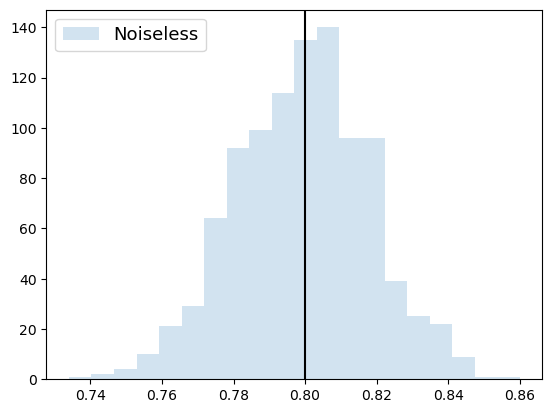

In [13]:
plt.hist(noiseless_list, alpha=0.2, bins=20, label=f"Noiseless")
plt.axvline(noiseless_expec_value, color="black")
plt.legend(loc="upper left", fontsize=13)
plt.show()

In [14]:
#サンプリングにより物理量の平均値を求める
shots = 100

#エラーありの場合
p = 0.3
gate = DepolarizingNoise(0, p)
gate.update_quantum_state(density_matrix)
noise_sampling = density_matrix.sampling(shots)

estimated_Z_average = 0.0
#物理量Zのサンプリングからの平均値は、測定結果がゼロのときは＋１、測定結果が１のときは－１を加える→サンプリング回数で割る、のようにして求める
for i in range(shots):
    estimated_Z_average += (-2*noise_sampling[i]+1)/shots

#物理量Zの期待値とサンプリングからの平均値を比較してみる
print("エラーがある場合")
print("サンプリングから推定したZの平均値",estimated_Z_average)
print("Zの期待値",Z0.get_expectation_value(density_matrix))

エラーがある場合
サンプリングから推定したZの平均値 0.4000000000000002
Zの期待値 0.48


In [15]:
#ヒストグラムを作成
n_test = 1000
shots = 1000
noisy_list = np.zeros(n_test)

for i in range(n_test):
    noisy_sampling = density_matrix.sampling(shots)
    estimated_Z_average = 0.0
    for j in range(shots):
        estimated_Z_average += (-2*noisy_sampling[j]+1)/shots
    noisy_list[i] = estimated_Z_average
noisy_expec_value = Z0.get_expectation_value(density_matrix)

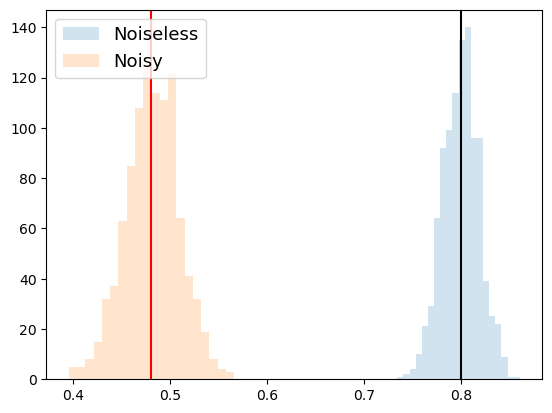

In [16]:
plt.hist(noiseless_list, alpha=0.2, bins=20, label=f"Noiseless")
plt.hist(noisy_list, alpha=0.2, bins=20, label=f"Noisy")
plt.axvline(noiseless_expec_value, color="black")
plt.axvline(noisy_expec_value, color="red")
plt.legend(loc="upper left", fontsize=13)
plt.show()

In [17]:
#２量子ビットの場合の密度演算子からサンプリング
shots = 30
mat3 = np.array([[0.5, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.3, 0.0], [0.0, 0.0, 0.0, 0.2]])
density_matrix_2.load(mat3)
noiseless_sampling_2 = density_matrix_2.sampling(shots)

print("サンプリングで得られたビット列",noiseless_sampling_2)
print(density_matrix_2)

サンプリングで得られたビット列 [2, 2, 0, 2, 0, 2, 0, 0, 2, 0, 3, 2, 2, 2, 3, 2, 0, 2, 2, 0, 2, 2, 0, 0, 2, 3, 2, 2, 2, 0]
 *** Density Matrix ***
 * Qubit Count : 2
 * Dimension   : 4
 * Density matrix : 
(0.5,0)   (0,0)   (0,0)   (0,0)
  (0,0)   (0,0)   (0,0)   (0,0)
  (0,0)   (0,0) (0.3,0)   (0,0)
  (0,0)   (0,0)   (0,0) (0.2,0)



測定結果はゼロ以上の整数（上の例なら、0, 2, 3のどれか）が得られる。２進数表示したときのビット列が、各量子ビットの測定結果に対応している。
２量子ビットの場合は以下の通り。
\begin{align}
0 &\rightarrow 00\\
1 &\rightarrow 01\\
2 &\rightarrow 10\\
3 &\rightarrow 11\\
\end{align}

## Lindblad方程式のシミュレーション：`NoisyEvolution_fast()`

環境からの影響を取り入れた量子開放系のダイナミクスのシミュレーションを行なう。
方程式は以下の通り。
\begin{align}
\frac{d}{dt} \rho(t) = -i[H,\rho(t)] +\sum_k \left(L_k \rho(t) L_k^\dagger -\frac{1}{2}L_k^\dagger L_k \rho(t)-\frac{1}{2} \rho(t)L_k^\dagger L_k\right).
\end{align}
ここで、$\rho(t)$は時刻$t$における系の密度演算子、$H$はハミルトニアン、$L_k$はリンドブラッド演算子である。
簡単な例として、以下の１量子ビット系の場合を考える。
\begin{align}
\frac{d}{dt} \rho(t) = -iJ[Z,\rho(t)] +\gamma \left(Z \rho(t) Z -\rho(t)\right).
\end{align}
$H=JZ$, $L_k = \sqrt{\gamma}Z$として、$k$は一つだけの場合をシミュレーションする。
初期状態は$|+\rangle$として時間発展した場合、時刻$t$における物理量$X$の期待値は以下のようになる。
\begin{align}
\langle X\rangle_t = e^{-2\gamma t} \cos{2Jt}
\end{align}

In [18]:
#qulacsを使ったLindblad方程式のシミュレーション
n = 1
T = 1.5
element = 40
tlist = np.linspace(0, T, element)

#物理量はXにする
observable = Observable(n)
observable.add_operator(1., "X 0")

#HamiltonianはZとする
hamiltonian = Observable(n)
J = 5.0
hamiltonian.add_operator(J, "Z 0 ")

#Lindblad演算子を指定
decay_rate_z = 0.3
c_ops = [GeneralQuantumOperator(n) for _ in range(n)]
c_ops[0].add_operator(np.sqrt(decay_rate_z), "Z 0")

#期待値をサンプリングにより求める
n_samples = 100
state = QuantumState(n)
exp_list = []
exp2_list = []
for t in tlist:
    exp = np.zeros(n_samples)
    for i in range(n_samples):
        state.set_zero_state()
        H(0).update_quantum_state(state)
        gate = NoisyEvolution_fast(hamiltonian, c_ops, t)
        gate.update_quantum_state(state)
        exp[i] = observable.get_expectation_value(state)
    exp_list.append(np.average(exp))
    exp2_list.append(np.std(exp)/np.sqrt(n_samples))

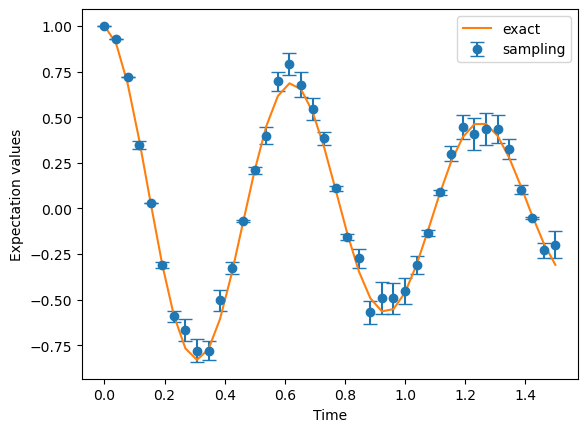

In [19]:
plt.figure()
plt.errorbar(tlist, exp_list, exp2_list, capsize=5, fmt='o',label=f"sampling")
plt.plot(tlist,np.exp(-2.0*decay_rate_z*tlist)*np.cos(2.0*J*tlist),label=f"exact")
plt.ylabel("Expectation values")
plt.xlabel("Time")
plt.legend()
plt.show()

QulacsではLindbladによる時間発展をモンテカルロ的に実行しているので、何度も実行して平均を取る必要があります。

## 練習
- ２つの量子状態（純粋状態$|\psi\rangle=\sqrt{\frac{3}{4}}|0\rangle+\sqrt{\frac{1}{4}}|1\rangle$、混合状態$\rho=\frac{3}{4}|0\rangle\langle0|+\frac{1}{4}|1\rangle\langle1|$）に対して、物理量の期待値XとZを求めてみましょう。
- ２量子ビットの場合で、ノイズが作用した状態（密度演算子）を作成してみましょう。`DepolarizingNoise`が１量子ビット目と２量子ビット目に作用した状態と、`TwoQubitDepolarizingNoise`が作用した状態が一般に異なることを確認してください。

## 補足：
変分量子アルゴリズムなどでは、`QuantumCircuit,  ParametricQuantumCircuit`を使いますが、このとき`circuit.add_gate(DepolarizingNoise(0, 0.15))`のように使えばOK。

In [20]:
from qulacs import QuantumCircuit,  ParametricQuantumCircuit

n_qubits = 1
p = 0.15
density_matrix.load(mat)
circuit = QuantumCircuit(n_qubits)
circuit.add_gate(DepolarizingNoise(0, p))
circuit.update_quantum_state(density_matrix)
print(density_matrix)

 *** Density Matrix ***
 * Qubit Count : 1
 * Dimension   : 2
 * Density matrix : 
(0.5,0) (0.4,0)
(0.4,0) (0.5,0)



In [21]:
density_matrix.load(mat)
n_qubits = 1
p = 0.15
Parametric_circuit = ParametricQuantumCircuit(n_qubits)
Parametric_circuit.add_gate(DepolarizingNoise(0, 0.15))
Parametric_circuit.update_quantum_state(density_matrix)
print(density_matrix)

 *** Density Matrix ***
 * Qubit Count : 1
 * Dimension   : 2
 * Density matrix : 
(0.5,0) (0.4,0)
(0.4,0) (0.5,0)

